# Magnetic Lineament Clustering in the Ponta Grossa Arc Region

This notebook demonstrates how we:
1. **Import** geospatial data of magnetic lineaments (line occurrences).
2. **Analyze** their strike angles.
3. **Cluster** them into distinct families using Jenks Natural Breaks.
4. **Validate** statistical significance (Shapiro–Wilk, Kruskal–Wallis, Dunn post-hoc).
5. **Interpret** the results in a geological context—particularly referencing Riccomini (1995), which discusses the multi-phase post-Gondwana tectonic evolution of southeastern Brazil.

## Geological Context and Motivation
The Ponta Grossa Arc is a major structural feature in southern Brazil, known for its role in the breakup of Gondwana (Early Cretaceous) and subsequent reactivation phases. Riccomini (1995) shows how lineaments in this region often represent pre-existing basement structures reactivated under different stress regimes, especially during the Mesozoic and Cenozoic. By clustering the lineaments’ strike angles, we can highlight possible structural families that correlate to distinct tectonic episodes (e.g., NW–SE or ENE–WSW sets).

In [1]:
# Library Imports and Data Reading

import pandas as pd
import numpy as np
import geopandas as gpd

# stats libs
import jenkspy as jks
import scipy.stats as sps
import scikit_posthocs as sp

# plotting libs
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
gdf = gpd.read_file('base_total.shp') # contains the lineaments
gdf1 = gpd.read_file('contorno.shp')  # represents the study area outline

In [3]:
gdf.head()

,Entity,X1,Y1,X2,Y2,Angle,geometry
0,LWPolyline,643008.298646,7.204962e+06,670984.850540,7.175962e+06,136.029552,"LINESTRING (-49.57984 -25.26491, -49.50266 -25..."
1,LWPolyline,714292.742519,7.147610e+06,743995.207067,7.110769e+06,141.122756,"LINESTRING (-48.86312 -25.77396, -48.81541 -25..."
2,LWPolyline,724764.471940,7.127092e+06,732943.646083,7.119593e+06,132.517285,"LINESTRING (-48.75526 -25.95753, -48.6723 -26...."
3,LWPolyline,735960.688204,7.119883e+06,750783.445955,7.107536e+06,129.793795,"LINESTRING (-48.64222 -26.02079, -48.58414 -26..."
4,LWPolyline,729889.672750,7.123095e+06,747113.391987,7.105537e+06,135.550395,"LINESTRING (-48.70341 -25.99279, -48.65778 -26..."


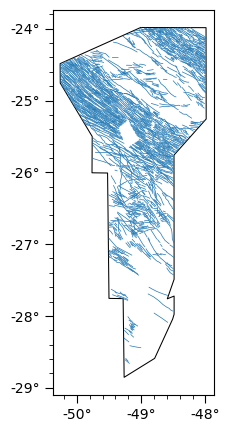

In [4]:
fig, ax = plt.subplots(figsize=(3.5,5))

gdf1.plot(ax=ax, color='black', linewidth=0.75)
gdf.plot(ax=ax, linewidth=0.5, color='tab:blue')

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='minor', direction='out', size=3)
ax.tick_params(which='major', direction='out', size=6)

x_min, x_max = ax.get_xlim()
x_ticks = np.arange(int(x_min), int(x_max) + 1, 1)
ax.xaxis.set_major_locator(FixedLocator(x_ticks))  
ax.xaxis.set_major_formatter(FixedFormatter([f"{int(tick)}\u00B0" for tick in x_ticks]))

y_min, y_max = ax.get_ylim()
y_ticks = np.arange(int(y_min), int(y_max) + 1, 1)
ax.yaxis.set_major_locator(FixedLocator(y_ticks))  
ax.yaxis.set_major_formatter(FixedFormatter([f"{tick}\u00B0" for tick in y_ticks]))

plt.show()

- Below, we define functions to calculate the Goodness of Variance Fit (GVF) to decide how many clusters (K) best group our strike data.

### Goodness of Variance Fit (GVF)

A helpful metric to evaluate Jenks’ classification is the **Goodness of Variance Fit (GVF)**. Generally, we define:

$$
\text{GVF} = \frac{\text{SST} - \text{SSE}}{\text{SST}},
$$

where:

- **SST** (Total Sum of Squares) = overall data variance relative to the grand mean,  
  $$
  \text{SST} = \sum_{i=1}^{N} (x_i - \bar{x})^2,
  $$
- **SSE** (Sum of Squares of Errors) = sum of each cluster’s internal variance,  
  $$
  \text{SSE} = \sum_{c=1}^{K} \sum_{x_i \in c} (x_i - \bar{x}_c)^2,
  $$
- $\bar{x}$ is the global mean of the entire dataset,
- $\bar{x}_c$ is the mean of cluster $c$,
- $K$ is the total number of clusters (e.g., 3),
- $N$ is the total number of observations.

Thus, by testing different numbers of classes (e.g., K=1..10) and calculating GVF each time, we look for an “elbow” or plateau in the GVF curve that signals an optimal partitioning. In this project, K=3 provided a high GVF, supporting the presence of three distinct angle clusters.

The original implementation of GVF can be found [here](https://stats.stackexchange.com/questions/143974/jenks-natural-breaks-in-python-how-to-find-the-optimum-number-of-breaks).


In [5]:
def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

In [6]:
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jks.jenks_breaks(array, classes)

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - np.mean(array)) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

**What is Jenks Natural Breaks?**  
- Jenks breaks is a clustering algorithm that aims to minimize variance within each class and maximize the difference between classes.  
- Here, we are grouping strike angles (`Angle`) into K classes that best describe “natural” groupings.  

**Why Calculate GVF?**  
- The “Goodness of Variance Fit” (GVF) measures how well the data are partitioned. A higher GVF ~ 0.80+ is often considered “good,” meaning our clusters capture real structure in the data rather than random splits.

## Finding the Optimal Number of Clusters (K)

**Explanation:**  
- We loop through K=1 to K=10, computing a Jenks partition for each and storing the resulting GVF.  
- Then we plot K vs. GVF, looking for an “elbow” or plateau to select the optimal K.


In [7]:
data_strikes = gdf.Angle.tolist()

In [8]:
gvf = []
nclasses = 1
n_teste = []

while nclasses < 11:
    gvf.append(goodness_of_variance_fit(data_strikes, nclasses))
    n_teste.append(nclasses)
    nclasses += 1

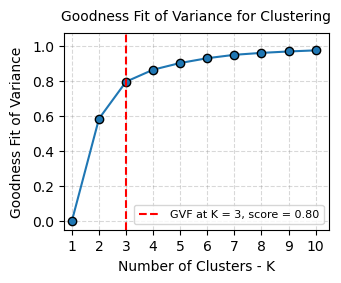

In [9]:
fig, ax = plt.subplots(figsize=(3.5,3))

ax.set_xlabel('Number of Clusters - K')
ax.set_ylabel('Goodness Fit of Variance')

ax.set_xlim(1*0.7,10*1.05)
ax.set_ylim(-0.05, max(gvf)*1.1)
ax.set_xticks(np.arange(1,11,1))

ax.xaxis.set_label_coords(.5, -0.15)
ax.yaxis.set_label_coords(-0.15, .5)

ax.set_title('Goodness Fit of Variance for Clustering', x=0.5, y=1.025, fontsize=10)

ax.plot(n_teste, gvf, marker='o', markeredgecolor= 'black', color='tab:blue')

ax.axvline(x = 3, linestyle='--', color = 'r', label = 'GVF at K = 3, score = %.2f' %(gvf[2]))

ax.grid(color = 'grey', linestyle='--', alpha=0.3)

ax.legend(loc='best', fontsize=8)

fig.tight_layout()
plt.show()

- A visible elbow around **K=3** and **K=4** often indicates the best compromise between model simplicity and capturing variance.  
- For this case and K=3 has a GVF=0.8 and supports the idea that three distinct clusters exist in our strike data, consistent with the multi‐modal distribution described by Riccomini (1995) for the Ponta Grossa Arc lineaments.

In [10]:
breaks = jks.jenks_breaks(data_strikes, 3)

Here, we confirm the final breakpoints for the three clusters. These will split the angles into three distinct groups, potentially correlating to three structural families (e.g., NW–SE, ENE–WSW, etc.).

In [11]:
# Freedman-Diaconis rule for histogram bin size

lista_quantile = np.quantile(data_strikes, q = np.arange(0.25, 1, 0.25))

In [12]:
q1 = lista_quantile[0]
q3 = lista_quantile[2]

iqr = q3 - q1

bin_width = (2 * iqr) / (len(data_strikes)**(1/3))
bin_count = int(np.ceil((max(data_strikes) - min(data_strikes)) / bin_width))

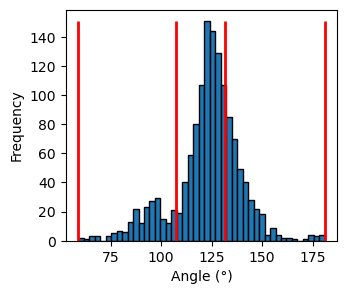

In [13]:
plt.figure(figsize = (3.5,3))

hist1 = plt.hist(data_strikes, color = 'tab:blue', edgecolor = 'black', bins = 45)

for b in breaks:
    plt.vlines(b, ymin=0, ymax = max(hist1[0]), color = 'red', linewidth = 2)

plt.xlabel('Angle (°)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.show()

In [14]:
breaks

[58.9734263877, 107.438112344, 131.700568485, 181.016599172]

- Now, we sort the angles and slice them according to the Jenks break indices, assigning each piece to a different cluster.

In [15]:
data_strikes = np.sort(gdf.Angle.tolist())

In [16]:
data_strikes_a = data_strikes[0:1+np.where(data_strikes == breaks[1])[0][0]]

In [17]:
data_strikes_b = data_strikes[1+np.where(data_strikes == breaks[1])[0][0]:1+np.where(data_strikes == breaks[2])[0][0]]

In [18]:
data_strikes_c = data_strikes[1+np.where(data_strikes == breaks[2])[0][0]:1+np.where(data_strikes == breaks[3])[0][0]]

In [19]:
tamanho_clusters = np.array([len(data_strikes_a), len(data_strikes_b), len(data_strikes_c)])

cluster = []
k = 3

for i in range(len(tamanho_clusters)):
    for j in range(tamanho_clusters[i]):
        cluster.append(k)
    k = k -1

In [20]:
gdf['cluster'] = cluster

In [21]:
gdfa = gdf[gdf.cluster==1]
gdfb = gdf[gdf.cluster==2]
gdfc = gdf[gdf.cluster==3]

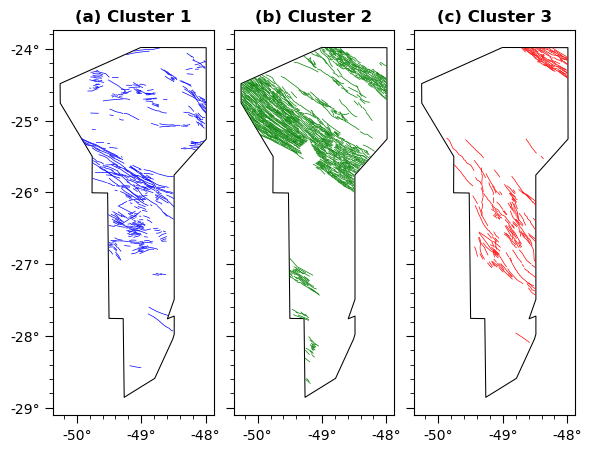

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10.5, 5))

# Function to format axes
def format_axes(ax):
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='minor', direction='out', size=3)
    ax.tick_params(which='major', direction='out', size=6)

    x_min, x_max = ax.get_xlim()
    x_ticks = np.arange(int(x_min), int(x_max) + 1, 1)
    ax.xaxis.set_major_locator(FixedLocator(x_ticks))
    ax.xaxis.set_major_formatter(FixedFormatter([f"{int(tick)}\u00B0" for tick in x_ticks]))

    y_min, y_max = ax.get_ylim()
    y_ticks = np.arange(int(y_min), int(y_max) + 1, 1)
    ax.yaxis.set_major_locator(FixedLocator(y_ticks))
    ax.yaxis.set_major_formatter(FixedFormatter([f"{int(tick)}\u00B0" for tick in y_ticks]))

# Plot each cluster
gdf1.plot(ax=ax1, color='black', linewidth=0.75)
gdfa.plot(ax=ax1, color='blue', linewidth=0.5)
ax1.set_title('(a) Cluster 1', fontsize=12, fontweight='bold')
format_axes(ax1)

gdf1.plot(ax=ax2, color='black', linewidth=0.75)
gdfb.plot(ax=ax2, color='green', linewidth=0.5)
ax2.set_title('(b) Cluster 2', fontsize=12, fontweight='bold')
format_axes(ax2)

gdf1.plot(ax=ax3, color='black', linewidth=0.75)
gdfc.plot(ax=ax3, color='red', linewidth=0.5)
ax3.set_title('(c) Cluster 3', fontsize=12, fontweight='bold')
format_axes(ax3)

plt.subplots_adjust(wspace=-0.6)

plt.show()

- By seeing the spatial pattern of each cluster, we can hypothesize that one cluster may represent the main set of NW–SE diques from the Serra Geral event, while others represent ENE–WSW or E–W reactivations from later tectonic pulses (cf. Riccomini, 1995).

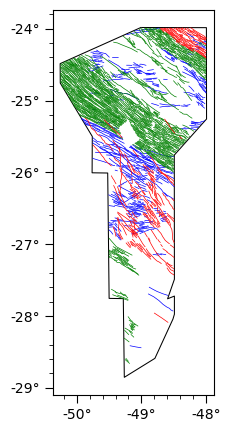

In [23]:
fig, ax = plt.subplots(figsize=(3.5, 5))

# Plot data
gdf1.plot(ax=ax, color='black', linewidth=0.75)
gdfa.plot(ax=ax, color='blue', linewidth=0.5)
gdfb.plot(ax=ax, color='green', linewidth=0.5)
gdfc.plot(ax=ax, color='red', linewidth=0.5)

# Minor ticks and tick parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='minor', direction='out', size=3)
ax.tick_params(which='major', direction='out', size=6)

# Set x-ticks
x_min, x_max = ax.get_xlim()
x_ticks = np.arange(int(x_min), int(x_max) + 1, 1)
ax.xaxis.set_major_locator(FixedLocator(x_ticks))
ax.xaxis.set_major_formatter(FixedFormatter([f"{int(tick)}\u00B0" for tick in x_ticks]))

# Set y-ticks
y_min, y_max = ax.get_ylim()
y_ticks = np.arange(int(y_min), int(y_max) + 1, 1)
ax.yaxis.set_major_locator(FixedLocator(y_ticks))
ax.yaxis.set_major_formatter(FixedFormatter([f"{int(tick)}\u00B0" for tick in y_ticks]))

plt.show()

## Rose/Polar Plot of the Strikes

Rose diagrams are standard in structural geology for quick orientation comparisons.

In [24]:
bin_edges = np.arange(-5, 366, 10)
number_of_strikes_a, bin_edges_a = np.histogram(data_strikes_a, bin_edges)
number_of_strikes_b, bin_edges_b = np.histogram(data_strikes_b, bin_edges)
number_of_strikes_c, bin_edges_c = np.histogram(data_strikes_c, bin_edges)

In [25]:
number_of_strikes_a[0] += number_of_strikes_a[-1]
number_of_strikes_b[0] += number_of_strikes_b[-1]
number_of_strikes_c[0] += number_of_strikes_c[-1]

In [26]:
half_a = np.sum(np.split(number_of_strikes_a[:-1], 2), 0)
two_halves_a = np.concatenate([half_a, half_a])

half_b = np.sum(np.split(number_of_strikes_b[:-1], 2), 0)
two_halves_b = np.concatenate([half_b, half_b])

half_c = np.sum(np.split(number_of_strikes_c[:-1], 2), 0)
two_halves_c = np.concatenate([half_c, half_c])

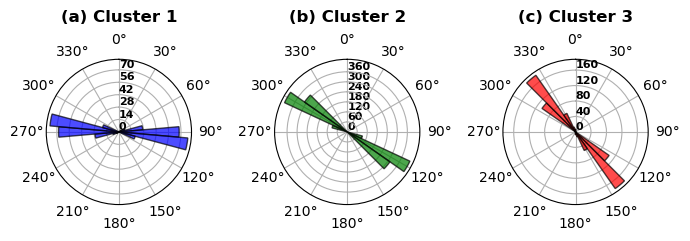

In [27]:
fig = plt.figure(figsize=(7,6))

# Plot cluster 1
ax1 = fig.add_subplot(131, projection='polar')
ax1.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves_a, width=np.deg2rad(10), bottom=0.0, color='blue', edgecolor='k', alpha=0.7)
ax1.set_theta_zero_location('N')
ax1.set_theta_direction(-1)
ax1.set_thetagrids(np.arange(0, 360, 30), labels=list(map(lambda x: str(x)+ u'\N{DEGREE SIGN}',np.arange(0, 360, 30))))
ax1.set_rgrids(np.arange(0, two_halves_a.max() + 1, 14), angle=0, weight= 'black', fontsize=8)
ax1.set_title('(a) Cluster 1', y=1.2, fontsize=12, fontweight='bold')
ax1.set_axisbelow(True)

# Plot cluster 2
ax2 = fig.add_subplot(132, projection='polar')
ax2.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves_b, width=np.deg2rad(10), bottom=0.0, color='green', edgecolor='k', alpha=0.7)
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_thetagrids(np.arange(0, 360, 30), labels=list(map(lambda x: str(x)+ u'\N{DEGREE SIGN}',np.arange(0, 360, 30))))
ax2.set_rgrids(np.arange(0, two_halves_b.max() + 1, 60), angle=0, weight= 'black', fontsize=8)
ax2.set_title('(b) Cluster 2', y=1.2, fontsize=12, fontweight='bold')
ax2.set_axisbelow(True)

# Plot cluster 3
ax3 = fig.add_subplot(133, projection='polar')
ax3.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves_c, width=np.deg2rad(10), bottom=0.0, color='red', edgecolor='k', alpha=0.7)
ax3.set_theta_zero_location('N')
ax3.set_theta_direction(-1)
ax3.set_thetagrids(np.arange(0, 360, 30), labels=list(map(lambda x: str(x)+ u'\N{DEGREE SIGN}',np.arange(0, 360, 30))))
ax3.set_rgrids(np.arange(0, two_halves_c.max() + 1, 40), angle=0, weight= 'black', fontsize=8)
ax3.set_title('(c) Cluster 3', y=1.2, fontsize=12, fontweight='bold')
ax3.set_axisbelow(True)

fig.tight_layout()
plt.show()

## Descriptive Stats

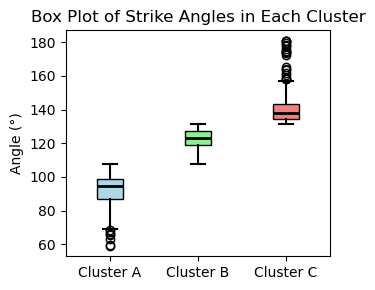

In [28]:
# Box Plot for the 3 Groups
fig2, ax2 = plt.subplots(figsize=(3.5, 3))

bp = ax2.boxplot(
    [data_strikes_a, data_strikes_b, data_strikes_c],
    patch_artist=True,
    tick_labels=['Cluster A', 'Cluster B', 'Cluster C']
)

box_colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)

for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=1.5)
for cap in bp['caps']:
    cap.set(color='black', linewidth=1.5)
for median in bp['medians']:
    median.set(color='black', linewidth=2)

ax2.set_title('Box Plot of Strike Angles in Each Cluster')
ax2.set_ylabel('Angle (°)')
plt.tight_layout()
plt.show()

In [29]:
df_clusters = pd.DataFrame({
    'Cluster A': pd.Series(data_strikes_a),
    'Cluster B': pd.Series(data_strikes_b),
    'Cluster C': pd.Series(data_strikes_c)
})

stats_table = df_clusters.describe()
display(stats_table)

,Cluster A,Cluster B,Cluster C
count,202.000000,820.000000,364.000000
mean,92.495777,122.604606,140.898110
std,9.951132,5.645567,9.384601
min,58.973426,107.579047,131.761310
25%,86.618299,118.776424,134.577813
50%,94.701545,123.322736,138.254664
75%,98.509391,127.163819,143.623416
max,107.438112,131.700568,181.016599


# Statistical Significance Tests

In this section, we verify whether the three identified angle clusters are statistically distinct. We employ:

1. **Shapiro–Wilk test** (normality check)
2. **Kruskal–Wallis test** (non-parametric omnibus test)
3. **Dunn’s post-hoc test** (pairwise comparison)

### Shapiro–Wilk Test for Normality

The **Shapiro–Wilk** test checks if our full dataset of strike angles follows a normal (Gaussian) distribution, a prerequisite for many parametric tests. Given that geological data can be multi-modal (due to multiple tectonic phases), we suspect it **won’t** be normally distributed.

The test statistic \( W \) is defined as:

$$
W = \frac{\left(\sum_{i=1}^{n} a_i \, x_{(i)}\right)^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2},
$$

where:
- $x_{(i)}$ is the $i$-th order statistic of the sample (i.e., the data sorted in ascending order),
- $a_i$ are constants derived from the means, variances, and covariances of the order statistics if the data were normal,
- $x_i$ are the observed data points,
- $\bar{x}$ is the sample mean,
- $n$ is the total number of observations.

**Null Hypothesis (H0):** Data are drawn from a normal distribution.

If the test yields a *p*-value below our chosen significance level (e.g., alpha = 0.05), we **reject** H0 and conclude that the data **are not** normally distributed. This result justifies using non-parametric methods to compare our clusters.

In [30]:
stat, p = sps.shapiro(data_strikes)

In [31]:
print('Shapiro-Wilk stat=%.3f, p=%.3E' % (stat, p))

if p < 0.05:
    print("Data are not normally distributed (reject H0).")
else:
    print("Data appear normally distributed (fail to reject H0).")

Shapiro-Wilk stat=0.950, p=3.276E-21
Data are not normally distributed (reject H0).


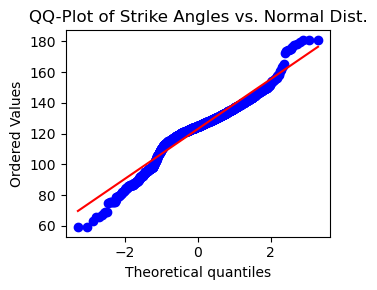

In [32]:
fig = plt.figure(figsize=(3.5, 3))
ax = fig.add_subplot(111)
sps.probplot(data_strikes, dist='norm', plot=ax)
ax.set_title("QQ-Plot of Strike Angles vs. Normal Dist.")
plt.tight_layout()
plt.show()

### Kruskal–Wallis Test for Multiple Groups

Since our data are not normal, we turn to a non-parametric alternative to ANOVA. The Kruskal–Wallis test checks whether three or more independent samples come from the same distribution. It ranks all observations from all groups combined, then sums those ranks by group.

The Kruskal–Wallis statistic 𝐻 is calculated approximately by:

$$
H \;=\; \frac{12}{N \,(N+1)} \,\sum_{i=1}^{g} \frac{R_i^2}{n_i} \;-\; 3\,(N+1),
$$

where:

- $g$ is the number of groups (in our case, 3 clusters),
- $n_i$ is the sample size of group $i$,
- $N = \sum_{i=1}^{g} n_i$ is the total sample size,
- $R_i$ is the sum of ranks in group $i$.

**Null Hypothesis (H₀)**: *All $g$ groups come from the same distribution.*

A *p*‑value < 0.05 indicates that **at least one** cluster’s distribution differs significantly from the others.

In [33]:
stat1, p1 = sps.kruskal(data_strikes_a, data_strikes_b, data_strikes_c)
print('Kruskal–Wallis stat=%.3f, p=%.3E' % (stat1, p1))

if p1 < 0.05:
    print("At least one cluster differs (reject H0).")
else:
    print("No significant difference among clusters (fail to reject H0).")

Kruskal–Wallis stat=1068.810, p=8.144E-233
At least one cluster differs (reject H0).


## Dunn’s Post‐hoc Test

When the Kruskal–Wallis test concludes that a difference exists, we want to know which pairs of clusters are distinct. For that, we use Dunn’s test, a non-parametric pairwise comparison similar to a Wilcoxon rank-sum test but adjusted for multiple groups.

A simplified version of **Dunn’s test statistic** $z_{ij}$ for comparing group $i$ and group $j$ is given by:

$$
z_{ij} = \frac{\bar{R}_i - \bar{R}_j}{\sqrt{\frac{N(N+1)}{12} \left( \frac{1}{n_i} + \frac{1}{n_j} \right) }}
$$

where:

- $\bar{R}_i$ is the **average rank** for group $i$,  
- $n_i$ is the sample size of group $i$,  
- $N$ is the total number of observations across all groups.

A p-value < 0.05 implies the pair is significantly different.

In [34]:
groups = [data_strikes_a, data_strikes_b, data_strikes_c]
pvals_matrix = sp.posthoc_dunn(groups, p_adjust='bonferroni')
print(pvals_matrix)

               1              2              3
1   1.000000e+00   6.321549e-59  4.467996e-216
2   6.321549e-59   1.000000e+00  1.778184e-121
3  4.467996e-216  1.778184e-121   1.000000e+00


## **Summary:**
1. **Three Distinct Strike Clusters**:  
   - Cluster A (mean): 92.5°
   - Cluster B (mean): 122.6°  
   - Cluster C (mean): 140.9°  
   
2. **Statistically Significant Differences**:  
   - Kruskal–Wallis p < 0.001, so each cluster is distinct from the others.  

3. **Geological Interpretation**:  
   - The results match well with the multi-phase tectonic framework in the Ponta Grossa Arc region:
     - A NW–SE or WNW–ESE set commonly tied to Mesozoic extensional events (Serra Geral diques)  
     - An E–W to ENE–WSW set possibly reflecting oblique reactivations or younger Andean compression phases  
     - Another near-E–W or NE–SW set that could be inherited from Brasiliano basement lineaments, reactivated in various episodes  

These conclusions align with Riccomini (1995), who documented multiple periods of deformation in the region post-Gondwana breakup.

**Next Steps or Future Work:**
- Extending the analysis with gravity or seismic data to better define the depth and continuity of these structures.
- Comparing lineament patterns with known intrusions or local fault scarps to see if they coincide with field-mapped structures.

**References:**
- Riccomini, C. (1995). Tectonismo gerador e deformador dos depósitos sedimentares pós-gondvânicos da porção centro-oriental do Estado de São Paulo e áreas vizinhas. Tese de Livre Docência, Instituto de Geociências, Universidade de São Paulo, São Paulo. doi:10.11606/T.44.2013.tde-03062013-103524. Recuperado em 2022-02-16, de www.teses.usp.br 
